**Importations utiles**

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, preprocessing

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix

**Données**

In [1]:
df = pd.read_csv('Building Energy Efficiency.csv')
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.7638,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.9800,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.9800,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.9800,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.9000,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [80]:
df.info()
# Le dataset est "propre"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative Compactness       768 non-null    float64
 1   Surface Area               768 non-null    float64
 2   Wall Area                  768 non-null    float64
 3   Roof Area                  768 non-null    float64
 4   Overall Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing Area               768 non-null    float64
 7   Glazing Area Distribution  768 non-null    int64  
 8   Heating Load               768 non-null    float64
 9   Cooling Load               768 non-null    float64
 10  charges_sum                768 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 66.1 KB


<AxesSubplot:>

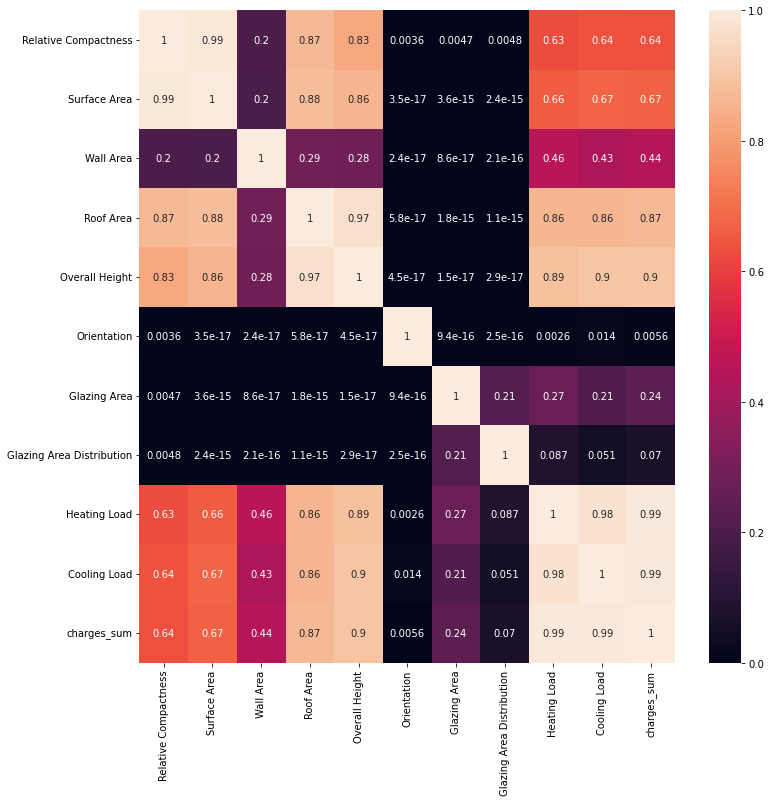

In [14]:
# Variables les plus corrélées avec les deux variables cibles :
cor = df.corr().abs()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(cor, annot = True, ax = ax)

Les variables les plus corrélées aux deux variables cibles sont "roof area" et "Overall Height", 
ce qui et assez logique : plus la maison est grande, plus on a besoin de chauffer / climatiser.

In [5]:
# Création d'une unique variable cible : charges de chauffage et de climatisation pour chaque immeuble :
column_list = ['Heating Load', 'Cooling Load']
df['charges_sum'] = df[column_list].sum(axis = 1)

In [8]:
# On découpe les immeubles en 4 classes distinctes selon les quartiles de la nouvelle variable cible :
charges_classes = pd.qcut(x = df['charges_sum'], q = 4, labels = [0,1,2,3])

**Séparation des données**

In [9]:
to_drop = ['Heating Load', 'Cooling Load', 'charges_sum']
data = df.drop(to_drop, axis = 1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, charges_classes, test_size = 0.2)

In [11]:
# Normalisation
scaler_train = preprocessing.StandardScaler().fit(X_train)
X_train = scaler_train.transform(X_train)

In [12]:
scaler_test = preprocessing.StandardScaler().fit(X_test)
X_test = scaler_test.transform(X_test)

**Sélection du modèle**

In [48]:
# Classifieurs :
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0, solver='liblinear'),
    "KNN" : KNeighborsClassifier(),
    "SVM" : SVC(random_state=0, probability=True),
    "NaiveBayes": GaussianNB(),
    "Perceptron" : Perceptron(),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), 
}


# Grilles de paramètres pour grid search :
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVM_grid = {'C': [0.25, 0.5, 0.75, 1, 1.5, 10, 30],
            'kernel': ['linear', 'sigmoid', 'rbf'],
            'gamma': ['scale', 'auto']}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

PC_grid = {'penalty' :['l2','l1','elasticnet']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

XGB_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}



# Dictionnaire de grilles :
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVM" : SVM_grid,
    "NaiveBayes": NB_grid,
    "Perceptron" : PC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : XGB_grid,
   }

In [51]:
# Grid Search

i=0
scores = pd.DataFrame({'Classifier' : classifiers.keys(), 'Accuracy': np.zeros(len(classifiers))})

for key, classifier in classifiers.items():
    clf = GridSearchCV(estimator = classifier, param_grid = grid[key])
    
    # Entraînement et score
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.iloc[i,1] = clf.score(X_test, y_test)
        
    # Affichages
    print(key)
    print('Score :', scores.iloc[i,1])
    print('Meilleurs paramètres :', clf.best_params_)
    print('Matrice de confusion : \n', confusion_matrix(y_test, y_pred))
    print('_' * 20, '\n')
    
    i+=1

LogisticRegression
Score : 0.8506493506493507
Meilleurs paramètres : {'C': 0.75, 'max_iter': 50, 'penalty': 'l1'}
Matrice de confusion : 
 [[36  6  0  0]
 [ 6 32  4  0]
 [ 0  0 29  0]
 [ 0  0  7 34]]
____________________ 

KNN
Score : 0.9090909090909091
Meilleurs paramètres : {'n_neighbors': 5, 'p': 1}
Matrice de confusion : 
 [[36  6  0  0]
 [ 2 37  3  0]
 [ 0  0 28  1]
 [ 0  0  2 39]]
____________________ 

SVM
Score : 0.922077922077922
Meilleurs paramètres : {'C': 30, 'gamma': 'scale', 'kernel': 'rbf'}
Matrice de confusion : 
 [[39  3  0  0]
 [ 0 36  6  0]
 [ 0  0 28  1]
 [ 0  0  2 39]]
____________________ 

NaiveBayes
Score : 0.43506493506493504
Meilleurs paramètres : {'var_smoothing': 1e-10}
Matrice de confusion : 
 [[ 0 42  0  0]
 [ 0 38  4  0]
 [ 0  0 29  0]
 [ 0  0 41  0]]
____________________ 

Perceptron
Score : 0.7792207792207793
Meilleurs paramètres : {'penalty': 'elasticnet'}
Matrice de confusion : 
 [[39  3  0  0]
 [11 27  4  0]
 [ 0  0 24  5]
 [ 0  0 11 30]]
___________

In [52]:
scores

,Classifier,Accuracy
0,LogisticRegression,0.850649
1,KNN,0.909091
2,SVM,0.922078
3,NaiveBayes,0.435065
4,Perceptron,0.779221
5,RandomForest,0.974026
6,XGBoost,0.961039


**Conclusion**

Le modèle Random forest semble avoir la meilleure précision pour ce dataset

In [55]:
rf = RandomForestClassifier(max_depth = 6, n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

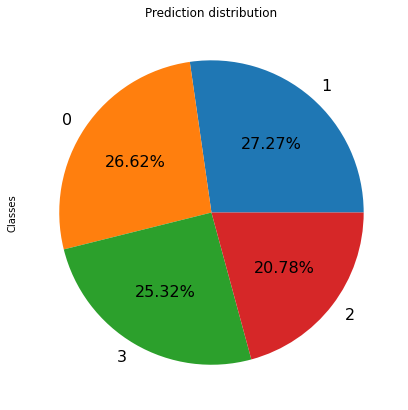

In [76]:
# Distribution des prédictions :
df_pred = pd.DataFrame(data = {'Classes' : y_pred})
plt.figure(figsize=(7,7))
df_pred['Classes'].value_counts().plot.pie(autopct='%1.2f%%', textprops={'fontsize':16}).set_title("Prediction distribution");